In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12120)])
  except RuntimeError as e:
    print(e)

In [2]:
# %matplotlib widget
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras import layers
import numpy as np
from tensorflow import keras
from os import listdir, makedirs

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, Reshape, Flatten, UpSampling2D, Conv2DTranspose, InputLayer
from tensorflow.keras.models import Sequential, Model
import sys
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from shutil import copyfile
import tensorflow as tf

In [83]:
dog_train = 'data/dog-cat-full-dataset/data/train/dogs/'
# cat_train = 'data/dog-cat-full-dataset/data/train/cats/'
dog_test = 'data/dog-cat-full-dataset/data/test/dogs/'
# cat_test = 'data/dog-cat-full-dataset/data/test/cats/'
ood = 'data/ood_monkey/'

In [84]:
dog_train_list = listdir(dog_train)
# cat_train_list = listdir(cat_train)
dog_test_list = listdir(dog_test)
# cat_test_list = listdir(cat_test)
ood_list = listdir(ood)
len(ood_list)

250

In [85]:
np.random.seed(1)
dog_train_samples=np.random.choice(dog_train_list, 1000)
# cat_train_samples=np.random.choice(cat_train_list, 1000)
dog_test_samples=np.random.choice(dog_test_list, 250)
# cat_test_samples=np.random.choice(cat_test_list, 250)

all_train = list(dog_train_samples.copy())
# all_train.extend(list(cat_train_samples))
all_test = list(dog_test_samples.copy())
# all_test.extend(list(cat_test_samples))
np.random.shuffle(all_test)
np.random.shuffle(all_train)

In [86]:
photos_train = list()
train_labels = list()
photos_test = list()
test_labels = list()
ood_test = list()
for file in ood_list:
    photo = load_img(ood+file, target_size=(128, 128))
    photo = img_to_array(photo)
    ood_test.append(photo/255.)
for file in all_train:
    if file.startswith('cat'):
        folder = cat_train
        train_labels.append(0)
    else:
        folder = dog_train
        train_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_train.append(photo/255.)
    
for file in all_test:
    if file.startswith('cat'):
        folder = cat_test
        test_labels.append(0)
    else:
        folder = dog_test
        test_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_test.append(photo/255.)

In [87]:
photos_train = np.asarray(photos_train)
train_labels = np.asarray(train_labels)
photos_test = np.asarray(photos_test)
test_labels = np.asarray(test_labels)
ood_test = np.asarray(ood_test)

In [88]:
print(photos_train.shape,photos_test.shape,ood_test.shape)
print(train_labels.shape,test_labels.shape)

(1000, 128, 128, 3) (250, 128, 128, 3) (250, 128, 128, 3)
(1000,) (250,)


In [89]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [90]:
def MSELoss(y_true, y_pred):
   return tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred))

In [91]:
Loss = SSIMLoss

In [92]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [93]:
cat_AE = Model(input_layer, output_layer)
cat_AE.compile(optimizer='adam', loss=Loss, metrics=['accuracy'])
cat_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         584 

In [94]:
encoder = Model(input_layer, code_layer, name='enc')
dec_inp = Input(shape=(16,16,8), name='dec_inp')

final_ae_layer = encoder.layers[-1]

for i,layer in enumerate(cat_AE.layers):
    if i <= 6:
        pass
    elif i == 7:
        d = layer(dec_inp)
    else:
        d = layer(d)
        
decoder = Model(dec_inp, d, name='dec')

encoder.summary()

decoder.summary()

Model: "enc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         584     

In [95]:
cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)

In [96]:
hist = cat_AE.fit(photos_train, photos_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                callbacks=[cb],
                validation_data=(photos_test, photos_test))

Epoch 1/20
32/32 [==============================] - 2s 43ms/step - loss: 0.7850 - accuracy: 0.4781 - val_loss: 0.6978 - val_accuracy: 0.6073
Epoch 2/20
32/32 [==============================] - 1s 22ms/step - loss: 0.6560 - accuracy: 0.5546 - val_loss: 0.6197 - val_accuracy: 0.5605
Epoch 3/20
32/32 [==============================] - 1s 25ms/step - loss: 0.6019 - accuracy: 0.5654 - val_loss: 0.5878 - val_accuracy: 0.5865
Epoch 4/20
32/32 [==============================] - 1s 19ms/step - loss: 0.5770 - accuracy: 0.5971 - val_loss: 0.5698 - val_accuracy: 0.5952
Epoch 5/20
32/32 [==============================] - 1s 20ms/step - loss: 0.5623 - accuracy: 0.6065 - val_loss: 0.5583 - val_accuracy: 0.6064
Epoch 6/20
32/32 [==============================] - 1s 21ms/step - loss: 0.5517 - accuracy: 0.6150 - val_loss: 0.5496 - val_accuracy: 0.6051
Epoch 7/20
32/32 [==============================] - 1s 20ms/step - loss: 0.5419 - accuracy: 0.6142 - val_loss: 0.5376 - val_accuracy: 0.6075
Epoch 8/20
32

In [97]:
enc_out_id = encoder.predict(photos_test[:250])
enc_out_od = encoder.predict(ood_test[:250])
enc_out_id = np.clip(enc_out_id, 0, 1)
enc_out_od = np.clip(enc_out_od, 0, 1)

In [103]:
enc_out_id.shape

(250, 16, 16, 8)

In [99]:
id_label = np.zeros(enc_out_id.shape[0])
od_label = np.ones(enc_out_od.shape[0])

In [100]:
enc_out2d_id = np.array([features_2d.flatten() for features_2d in enc_out_id])
enc_out2d_od = np.array([features_2d.flatten() for features_2d in enc_out_od])

In [101]:
enc_out2d = np.append(enc_out2d_id, enc_out2d_od, axis=0)
y_test = np.append(id_label, od_label, axis=0)

In [104]:
enc_out2d.shape

(500, 2048)

In [105]:
tsne5 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d5_1 = tsne5.fit_transform(enc_out2d)

tsne10 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d10_1 = tsne10.fit_transform(enc_out2d)

tsne20 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d20_1 = tsne20.fit_transform(enc_out2d)

tsne40 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d40_1 = tsne40.fit_transform(enc_out2d)

tsne45 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d45_1 = tsne45.fit_transform(enc_out2d)

tsne50 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d50_1 = tsne50.fit_transform(enc_out2d)
print('Dimensions after tSNE-2D:', X_tsne_2d5_1.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 7.591227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.019440
[t-SNE] KL divergence after 1000 iterations: 2.368046
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 9.471467


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 138.178955
[t-SNE] KL divergence after 1000 iterations: 2.287884
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 11.163221


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 127.068047
[t-SNE] KL divergence after 1000 iterations: 1.878282
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 12.939343


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.197975
[t-SNE] KL divergence after 1000 iterations: 1.383754
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 13.267230


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 118.951874
[t-SNE] KL divergence after 1000 iterations: 1.369195
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 13.570688


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.779434
[t-SNE] KL divergence after 1000 iterations: 1.233715
Dimensions after tSNE-2D: (500, 2)


In [106]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'gray', 'purple']
len(colours)


10

In [107]:
# fig = plt.figure(figsize=(15,10))
# fig.suptitle('Latent Vector (DogOD) Visualization with PCA+TSNE')
# ax = fig.add_subplot(231)
# ax.title.set_text('Perplexity 5')
# for i in range(2):
#     ax.scatter(X_tsne_2d5_1[y_test==i, 0], X_tsne_2d5_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)

# ax = fig.add_subplot(232)
# ax.title.set_text('Perplexity 10')
# for i in range(2):
#     ax.scatter(X_tsne_2d10_1[y_test==i, 0], X_tsne_2d10_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
# ax = fig.add_subplot(233)
# ax.title.set_text('Perplexity 20')
# for i in range(2):
#     ax.scatter(X_tsne_2d20_1[y_test==i, 0], X_tsne_2d20_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
# ax = fig.add_subplot(234)
# ax.title.set_text('Perplexity 40')
# for i in range(2):
#     ax.scatter(X_tsne_2d40_1[y_test==i, 0], X_tsne_2d40_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)

# ax = fig.add_subplot(235)
# ax.title.set_text('Perplexity 45')
# for i in range(2):
#     ax.scatter(X_tsne_2d45_1[y_test==i, 0], X_tsne_2d45_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
# ax = fig.add_subplot(236)
# ax.title.set_text('Perplexity 50')
# for i in range(2):
#     ax.scatter(X_tsne_2d50_1[y_test==i, 0], X_tsne_2d50_1[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)

# plt.savefig('Elab_DogOD_PCA_TSNE.png')

In [108]:
def distance(x,y):
    x=np.array(x)
    y=np.array(y)
    p=np.sum((x-y)**2)
    d=np.sqrt(p)
    return d

In [109]:
enc_out2d.shape

(500, 2048)

In [120]:
dist = list()
dist1 = list()
for i in range(250):
    dist.append(distance(X_tsne_2d5_1[0], X_tsne_2d5_1[250-i]))
    dist1.append(distance(X_tsne_2d5_1[0], X_tsne_2d5_1[i]))
dist = np.asarray(dist)
dist1 = np.asarray(dist1)

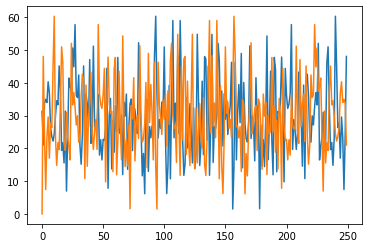

In [121]:
plt.plot(dist)
plt.plot(dist1)

In [64]:
 X_tsne_2d5_1[5]

array([ -1.8361237, -35.11927  ], dtype=float32)

In [47]:
tsne5 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d5 = tsne5.fit_transform(enc_out2d)

tsne10 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d10 = tsne10.fit_transform(enc_out2d)

tsne20 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d20 = tsne20.fit_transform(enc_out2d)

tsne40 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d40 = tsne40.fit_transform(enc_out2d)

tsne45 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d45 = tsne45.fit_transform(enc_out2d)

tsne50 = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200))
# tsne.fit(X, y)
X_tsne_2d50 = tsne50.fit_transform(enc_out2d)
print('Dimensions after tSNE-2D:', X_tsne_2d5.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 8.724652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 132.673279
[t-SNE] KL divergence after 1000 iterations: 2.419766
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 10.757004


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 132.680984
[t-SNE] KL divergence after 1000 iterations: 2.259670
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 12.614906


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 137.773224
[t-SNE] KL divergence after 1000 iterations: 2.317812
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 14.580149


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.756241
[t-SNE] KL divergence after 1000 iterations: 1.385187
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 14.942213


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.374969
[t-SNE] KL divergence after 1000 iterations: 1.310595
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 15.275604


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.445999
[t-SNE] KL divergence after 1000 iterations: 1.306517
Dimensions after tSNE-2D: (500, 2)


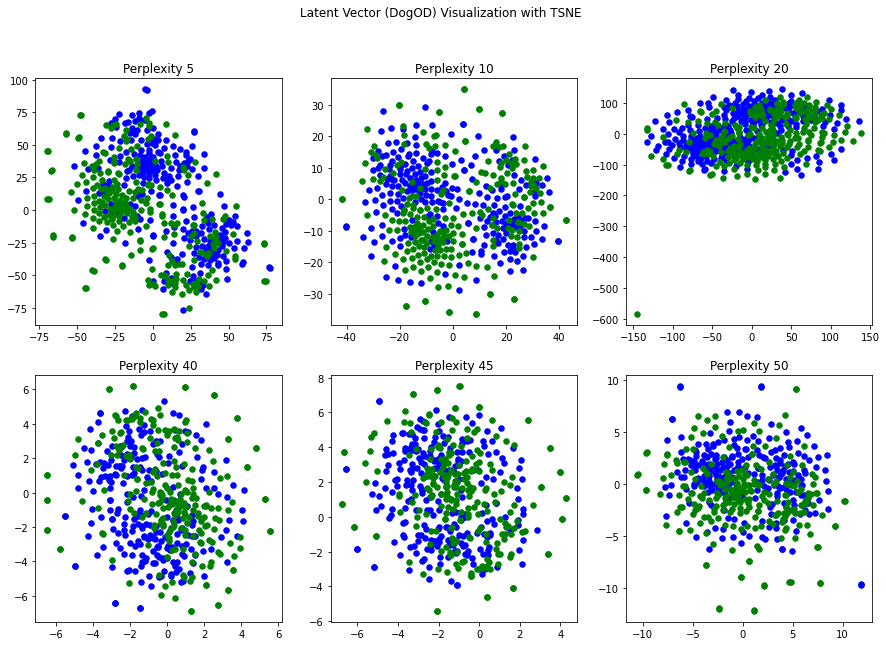

In [48]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Latent Vector (DogOD) Visualization with TSNE')
ax = fig.add_subplot(231)
ax.title.set_text('Perplexity 5')
for i in range(2):
    ax.scatter(X_tsne_2d5[y_test==i, 0], X_tsne_2d5[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)

ax = fig.add_subplot(232)
ax.title.set_text('Perplexity 10')
for i in range(2):
    ax.scatter(X_tsne_2d10[y_test==i, 0], X_tsne_2d10[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
ax = fig.add_subplot(233)
ax.title.set_text('Perplexity 20')
for i in range(2):
    ax.scatter(X_tsne_2d20[y_test==i, 0], X_tsne_2d20[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
ax = fig.add_subplot(234)
ax.title.set_text('Perplexity 40')
for i in range(2):
    ax.scatter(X_tsne_2d40[y_test==i, 0], X_tsne_2d40[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)

ax = fig.add_subplot(235)
ax.title.set_text('Perplexity 45')
for i in range(2):
    ax.scatter(X_tsne_2d45[y_test==i, 0], X_tsne_2d45[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
ax = fig.add_subplot(236)
ax.title.set_text('Perplexity 50')
for i in range(2):
    ax.scatter(X_tsne_2d50[y_test==i, 0], X_tsne_2d50[y_test==i, 1], c=colours[i], s=30, cmap='Set1', label=i)
    
plt.savefig('Elab_DogOD_TSNE.png')
